<a href="https://colab.research.google.com/github/baut-jc/ddds-c18/blob/main/Lectures/5-6c_Geographic_Data_and_Maps_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Why we care

A lot of data is inherently location-based and this trend is increasing.  
- Any data that is county, state, country, city, etc. is tied to a geographic location on the ground
- Addresses
- Photos
- Businesses
- Satelite imagery

In order to unlock the full power of this data or to visualize it, we need to really treat it as geographic data.  

Sometimes it's important to do things like:
- Test if an address is within a county
- Aggregate data
- Figure out distances between points


**This lecture will cover:**
- using maps to display data
- other operations on geographic data

# A few mapping basics


**Projections:**  
There are a lot of different projections that are used.  A projection refers to the process used to convert points on the earth (more or less a sphere) to a flat surface like a map or computer monitor.

(This is largely beyond our scope here, but it is can be very important to pay attention to if one is going to do a lot with GIS data.)


**Latitude** is degrees north or south of the equator.  (-90 to 90) Lines of latitude are parallel.

**Longitude** is degrees east or west of the prime meridian (-180 to 180).  Lines of longitude converge at the poles (not parallel).

# Libraries for mapping in Python
There are several choices for libraries for creating maps.  A few of them include:
- matplotblib- basemap - [Geographic Data with Basemap - Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.13-Geographic-Data-With-Basemap.ipynb)
- Plotly Express - https://plotly.com/python/maps/

- [Altair](https://altair-viz.github.io/gallery/index.html#maps) - Another diverse plotting library that includes some mapping options
- [Folium](https://python-visualization.github.io/folium/) - Specifically for mapping- powerful, interactive maps based on leaflet.js
  

In [39]:
%%capture
%%bash
apt-get update
apt-get install -y tree jq


In [40]:
%%capture
# Get updated version of plotly
!pip install plotly -U


In [41]:
%%capture
!pip install geopandas


In [42]:
import json
import numpy as np
import pandas as pd
import requests
import plotly.express as px
import geopandas as gpd
import geopy.distance


# COVID Data

**Choropleth** is really just a fancy name for a color-coded map where the color indicates something like population density or the number of positive covid cases.




Make request for the data.

In [43]:
!curl -L -O https://covidtracking.com/data/download/all-states-history.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2674k    0 2674k    0     0  4612k      0 --:--:-- --:--:-- --:--:-- 4611k


In [44]:
!head all-states-history.csv


"date","state","death","deathConfirmed","deathIncrease","deathProbable","hospitalized","hospitalizedCumulative","hospitalizedCurrently","hospitalizedIncrease","inIcuCumulative","inIcuCurrently","negative","negativeIncrease","negativeTestsAntibody","negativeTestsPeopleAntibody","negativeTestsViral","onVentilatorCumulative","onVentilatorCurrently","positive","positiveCasesViral","positiveIncrease","positiveScore","positiveTestsAntibody","positiveTestsAntigen","positiveTestsPeopleAntibody","positiveTestsPeopleAntigen","positiveTestsViral","recovered","totalTestEncountersViral","totalTestEncountersViralIncrease","totalTestResults","totalTestResultsIncrease","totalTestsAntibody","totalTestsAntigen","totalTestsPeopleAntibody","totalTestsPeopleAntigen","totalTestsPeopleViral","totalTestsPeopleViralIncrease","totalTestsViral","totalTestsViralIncrease"
"2021-03-07","AK",305,,0,,1293,1293,33,0,,,,0,,,1660758,,2,56886,,0,0,,,,,68693,,,0,1731628,0,,,,,,0,1731628,0
"2021-03-07","AL",10148,7963,-1,2

In [45]:
%%bash
# Verify that the downloaded data is the same data is in the /Data/ folder
# md5sum /content/drive/MyDrive/Data/all-states-history.csv
curl -L -s https://ddc-datascience.s3.amazonaws.com/all-states-history.csv | md5sum
md5sum all-states-history.csv


9b33482a251e34a59b63c084bffe9c36  -
9b33482a251e34a59b63c084bffe9c36  all-states-history.csv


In [46]:
# Pick one source and read it in.
# covid_csv="/content/drive/MyDrive/Data/all-states-history.csv"
covid_csv="all-states-history.csv"
covid_csv


'all-states-history.csv'

Turn data into data frame and take a peek.

In [47]:
state_df = pd.read_csv(covid_csv)
state_df.head()


,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-03-07,AK,305.0,NaN,0,NaN,1293.0,1293.0,33.0,0,...,1731628.0,0,NaN,NaN,NaN,NaN,NaN,0,1731628.0,0
1,2021-03-07,AL,10148.0,7963.0,-1,2185.0,45976.0,45976.0,494.0,0,...,2323788.0,2347,NaN,NaN,119757.0,NaN,2323788.0,2347,NaN,0
2,2021-03-07,AR,5319.0,4308.0,22,1011.0,14926.0,14926.0,335.0,11,...,2736442.0,3380,NaN,NaN,NaN,481311.0,NaN,0,2736442.0,3380
3,2021-03-07,AS,0.0,NaN,0,NaN,NaN,NaN,NaN,0,...,2140.0,0,NaN,NaN,NaN,NaN,NaN,0,2140.0,0
4,2021-03-07,AZ,16328.0,14403.0,5,1925.0,57907.0,57907.0,963.0,44,...,7908105.0,45110,580569.0,NaN,444089.0,NaN,3842945.0,14856,7908105.0,45110


See how many entries we have.

In [48]:
state_df.shape


(20780, 41)

In [49]:
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20780 entries, 0 to 20779
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              20780 non-null  object 
 1   state                             20780 non-null  object 
 2   death                             19930 non-null  float64
 3   deathConfirmed                    9422 non-null   float64
 4   deathIncrease                     20780 non-null  int64  
 5   deathProbable                     7593 non-null   float64
 6   hospitalized                      12382 non-null  float64
 7   hospitalizedCumulative            12382 non-null  float64
 8   hospitalizedCurrently             17339 non-null  float64
 9   hospitalizedIncrease              20780 non-null  int64  
 10  inIcuCumulative                   3789 non-null   float64
 11  inIcuCurrently                    11636 non-null  float64
 12  nega

We have an entry for every day for every state and we just want the most recent data.

In [50]:
type(state_df['date'][0])


str

Dates are currently strings.  We need to turn them into DateTime objects.

In [51]:
state_df['date'] = pd.to_datetime(state_df['date'])
state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20780 entries, 0 to 20779
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              20780 non-null  datetime64[ns]
 1   state                             20780 non-null  object        
 2   death                             19930 non-null  float64       
 3   deathConfirmed                    9422 non-null   float64       
 4   deathIncrease                     20780 non-null  int64         
 5   deathProbable                     7593 non-null   float64       
 6   hospitalized                      12382 non-null  float64       
 7   hospitalizedCumulative            12382 non-null  float64       
 8   hospitalizedCurrently             17339 non-null  float64       
 9   hospitalizedIncrease              20780 non-null  int64         
 10  inIcuCumulative                   3789 non-nul

In [52]:
state_df['date'].sample(n=5, random_state=42)


,date
803,2021-02-21
20402,2020-03-07
19425,2020-03-26
19600,2020-03-22
10246,2020-09-06


Now we have it as a Timestamp

In [53]:
state_df['date'].max()


Timestamp('2021-03-07 00:00:00')

Grab the latest data they do have which is March 7th, 2021.

In [54]:
filter = ( state_df['date']==state_df['date'].max() )
march_df = state_df[ filter ]


In [55]:
march_df.head()


,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
0,2021-03-07,AK,305.0,NaN,0,NaN,1293.0,1293.0,33.0,0,...,1731628.0,0,NaN,NaN,NaN,NaN,NaN,0,1731628.0,0
1,2021-03-07,AL,10148.0,7963.0,-1,2185.0,45976.0,45976.0,494.0,0,...,2323788.0,2347,NaN,NaN,119757.0,NaN,2323788.0,2347,NaN,0
2,2021-03-07,AR,5319.0,4308.0,22,1011.0,14926.0,14926.0,335.0,11,...,2736442.0,3380,NaN,NaN,NaN,481311.0,NaN,0,2736442.0,3380
3,2021-03-07,AS,0.0,NaN,0,NaN,NaN,NaN,NaN,0,...,2140.0,0,NaN,NaN,NaN,NaN,NaN,0,2140.0,0
4,2021-03-07,AZ,16328.0,14403.0,5,1925.0,57907.0,57907.0,963.0,44,...,7908105.0,45110,580569.0,NaN,444089.0,NaN,3842945.0,14856,7908105.0,45110


In [56]:
march_df.columns


Index(['date', 'state', 'death', 'deathConfirmed', 'deathIncrease',
       'deathProbable', 'hospitalized', 'hospitalizedCumulative',
       'hospitalizedCurrently', 'hospitalizedIncrease', 'inIcuCumulative',
       'inIcuCurrently', 'negative', 'negativeIncrease',
       'negativeTestsAntibody', 'negativeTestsPeopleAntibody',
       'negativeTestsViral', 'onVentilatorCumulative', 'onVentilatorCurrently',
       'positive', 'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral', 'totalTestsViralIncrease'

## Choropleth Map

In [57]:
fig = px.choropleth(
    march_df,
    locations='state',
    locationmode='USA-states',
    color='positive',
    color_continuous_scale="Viridis",
    scope="usa",
    labels={'positive':'Positive Tests'}
)
fig.show() ;


## Choropleth with Animation

Now let's look at April 2020.

In [58]:
# Look at April 2020
filter = ( (state_df['date'] >= '2020-04-01') & (state_df['date'] < '2020-05-01') )
covid_apr = state_df[ filter ]
covid_apr_2 = covid_apr.copy()

# Create new column that is the day of the month
covid_apr_2['day'] = covid_apr['date'].dt.day

# Sort data frame by day
covid_apr_2.sort_values(by = 'day', inplace = True)


In [59]:
covid_apr_2

,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease,day
19064,2020-04-01,MI,676.0,765.0,125,35.0,NaN,NaN,NaN,0,...,6133,NaN,NaN,NaN,NaN,NaN,0,43188.0,6133,1
19065,2020-04-01,MN,17.0,NaN,5,NaN,122.0,122.0,54.0,10,...,1002,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1
19066,2020-04-01,MO,18.0,NaN,4,NaN,NaN,NaN,NaN,0,...,2767,NaN,NaN,NaN,NaN,NaN,0,21956.0,2767,1
19067,2020-04-01,MP,1.0,NaN,0,NaN,NaN,NaN,NaN,0,...,4,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1
19068,2020-04-01,MS,22.0,NaN,2,NaN,332.0,332.0,NaN,121,...,311,NaN,NaN,NaN,NaN,NaN,0,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17434,2020-04-30,KS,129.0,NaN,4,NaN,523.0,523.0,NaN,8,...,2168,NaN,NaN,NaN,NaN,NaN,0,NaN,0,30
17433,2020-04-30,IN,1114.0,NaN,49,NaN,NaN,NaN,1466.0,0,...,6239,NaN,NaN,NaN,NaN,NaN,0,127373.0,6239,30
17432,2020-04-30,IL,2355.0,NaN,140,NaN,NaN,NaN,4953.0,0,...,13200,NaN,NaN,NaN,NaN,NaN,0,269867.0,13200,30
17431,2020-04-30,ID,60.0,NaN,0,NaN,175.0,175.0,36.0,2,...,453,NaN,NaN,NaN,NaN,28693.0,453,NaN,0,30


In [60]:
fig = px.choropleth(
    covid_apr_2,
    locations='state',
    locationmode='USA-states',
    color='hospitalizedCurrently',
    color_continuous_scale="Viridis",
    scope="usa",
    labels={'positive':'Positive Tests'},
    animation_frame = 'day',
    range_color=(0, 19000),
)
fig.show() ;


In [61]:
# export animation to HTML file for viewing in an HTML page
fig.write_html(file="map.html")

# ABQ Police Incidents

- [APD ArcGIS REST service](https://coagisweb.cabq.gov/arcgis/rest/services/public/APD_Incidents/MapServer/0/query)
- [APD ArcGIS REST Docs](https://coagisweb.cabq.gov/arcgis/sdk/rest/index.html#//02ss0000000r000000)


Import data and take a look at it.

In [62]:
query = 'https://coagisweb.cabq.gov/arcgis/rest/services/public/APD_Incidents/MapServer/0/query?'
attr = '''
  where=1%3D1
  text=
  objectIds=
  time=
  geometry=
  geometryType=esriGeometryEnvelope
  inSR=
  spatialRel=esriSpatialRelIntersects
  relationParam=
  outFields=*
  returnGeometry=true
  maxAllowableOffset=
  geometryPrecision=
  outSR=4326
  returnIdsOnly=false
  returnCountOnly=false
  orderByFields=
  groupByFieldsForStatistics=
  outStatistics=
  returnZ=false
  returnM=false
  gdbVersion=
  returnDistinctValues=false
  f=pjson
'''.split()
incidents_url = query + "&".join(attr)
incidents_url


'https://coagisweb.cabq.gov/arcgis/rest/services/public/APD_Incidents/MapServer/0/query?where=1%3D1&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&f=pjson'

Take a look at one entry

In [63]:
# # Use curl to fetch the data as JSON
!curl -L "{incidents_url}" > apd.incidents.json


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7810k  100 7810k    0     0   612k      0  0:00:12  0:00:12 --:--:--  818k


In [64]:
# ... or download an older copy
# !curl -L 'https://ddc-datascience.s3.amazonaws.com/apd.incidents.json' > apd.incidents.json

In [65]:
ls -la apd*

-rw-r--r-- 1 root root 7998030 Jul  9 17:37 apd.incidents.json


In [66]:
# Peak at the first 300 characters
!head -c 300 apd.incidents.json


{
 "displayFieldName": "IncidentType",
 "fieldAliases": {
  "OBJECTID": "OBJECTID",
  "BlockAddress": "Location",
  "IncidentType": "Description",
  "ReportDateTime": "ReportDateTime"
 },
 "geometryType": "esriGeometryPoint",
 "spatialReference": {
  "wkid": 4326,
  "latestWkid": 4326
 },
 "fields":

In [67]:
!jq . apd.incidents.json | head -200


{
  "displayFieldName": "IncidentType",
  "fieldAliases": {
    "OBJECTID": "OBJECTID",
    "BlockAddress": "Location",
    "IncidentType": "Description",
    "ReportDateTime": "ReportDateTime"
  },
  "geometryType": "esriGeometryPoint",
  "spatialReference": {
    "wkid": 4326,
    "latestWkid": 4326
  },
  "fields": [
    {
      "name": "OBJECTID",
      "type": "esriFieldTypeOID",
      "alias": "OBJECTID"
    },
    {
      "name": "BlockAddress",
      "type": "esriFieldTypeString",
      "alias": "Location",
      "length": 60
    },
    {
      "name": "IncidentType",
      "type": "esriFieldTypeString",
      "alias": "Description",
      "length": 250
    },
    {
      "name": "ReportDateTime",
      "type": "esriFieldTypeDate",
      "alias": "ReportDateTime",
      "length": 8
    }
  ],
  "features": [
    {
      "attributes": {
        "OBJECTID": 942649,
        "BlockAddress": "4600 BLOCK CARLISLE BLVD NE",
        "IncidentType": "39 DISTURBANCE",
        "ReportDate

In [68]:
# Verify that the file downloaded is that same as what's in the data folder ( will likely be different with new data )
!ls -la /content/drive/MyDrive/Data/apd.incidents.json apd.incidents.json
!md5sum /content/drive/MyDrive/Data/apd.incidents.json apd.incidents.json


ls: cannot access '/content/drive/MyDrive/Data/apd.incidents.json': No such file or directory
-rw-r--r-- 1 root root 7998030 Jul  9 17:37 apd.incidents.json
md5sum: /content/drive/MyDrive/Data/apd.incidents.json: No such file or directory
012db3bc84984f9de7ef4d6b1cfcda14  apd.incidents.json


In [69]:
# Extract the first feature using jq
!jq .features[0] apd.incidents.json


{
  "attributes": {
    "OBJECTID": 942649,
    "BlockAddress": "4600 BLOCK CARLISLE BLVD NE",
    "IncidentType": "39 DISTURBANCE",
    "ReportDateTime": 1719297319000
  },
  "geometry": {
    "x": -106.60409831857645,
    "y": 35.13296910292757
  }
}


In [70]:
# Load the data into a Python dictionary
with open("apd.incidents.json") as file:
  incidents_import = json.loads(file.read())


In [71]:
# Look at the keys
incidents_import.keys()


dict_keys(['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features', 'exceededTransferLimit'])

In [72]:
# Grab the first incident
# incidents_import = requests.get(incidents_url).json()  ## <-- this should have worked, but didn't
features = incidents_import['features']
first = features[0]
first


{'attributes': {'OBJECTID': 942649,
  'BlockAddress': '4600 BLOCK CARLISLE BLVD NE',
  'IncidentType': '39 DISTURBANCE',
  'ReportDateTime': 1719297319000},
 'geometry': {'x': -106.60409831857645, 'y': 35.13296910292757}}

Turn our data into a dataframe and drop NAs.

In [73]:
incidents = pd.DataFrame(features)
incidents.dropna(inplace=True)
incidents.head()


,attributes,geometry
0,"{'OBJECTID': 942649, 'BlockAddress': '4600 BLO...","{'x': -106.60409831857645, 'y': 35.13296910292..."
1,"{'OBJECTID': 942650, 'BlockAddress': '800 BLOC...","{'x': -106.63821932535551, 'y': 35.08178509226..."
2,"{'OBJECTID': 942651, 'BlockAddress': '6500 BLO...","{'x': -106.57431128329294, 'y': 35.07542106406..."
3,"{'OBJECTID': 942652, 'BlockAddress': '5400 BLO...","{'x': -106.58155471383914, 'y': 35.06011093166..."
4,"{'OBJECTID': 942653, 'BlockAddress': '9000 BLO...","{'x': -106.68213854978926, 'y': 35.18603718603..."


In [74]:
incidents.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   attributes  30000 non-null  object
 1   geometry    30000 non-null  object
dtypes: object(2)
memory usage: 468.9+ KB


In [75]:
type(incidents["attributes"][0])


dict

In [76]:
type(incidents["geometry"][0])


dict

Extract data into separate columns.

In [77]:
incidents['geometry'][:10]

,geometry
0,"{'x': -106.60409831857645, 'y': 35.13296910292..."
1,"{'x': -106.63821932535551, 'y': 35.08178509226..."
2,"{'x': -106.57431128329294, 'y': 35.07542106406..."
3,"{'x': -106.58155471383914, 'y': 35.06011093166..."
4,"{'x': -106.68213854978926, 'y': 35.18603718603..."
5,"{'x': -106.50625931911293, 'y': 35.09070803212..."
6,"{'x': -106.7020584495678, 'y': 35.080381527713..."
7,"{'x': -106.6294540022926, 'y': 35.10552659081715}"
8,"{'x': -106.55352187630312, 'y': 35.09456514203..."
9,"{'x': -106.55057145138059, 'y': 35.08734343989..."


In [78]:
incidents['geometry'][:10].apply(lambda entry: entry['x'])

,geometry
0,-106.604098
1,-106.638219
2,-106.574311
3,-106.581555
4,-106.682139
5,-106.506259
6,-106.702058
7,-106.629454
8,-106.553522
9,-106.550571


In [79]:
incidents['longitude'] = incidents['geometry'].apply(lambda entry: entry['x'])
incidents['latitude'] = incidents['geometry'].apply(lambda entry: entry['y'])
incidents['type'] = incidents['attributes'].apply(lambda entry: entry['IncidentType'])
incidents['address'] = incidents['attributes'].apply(lambda entry: entry['BlockAddress'])
incidents['datetime'] = incidents['attributes'].apply(lambda entry: entry['ReportDateTime'])

incidents.head()


,attributes,geometry,longitude,latitude,type,address,datetime
0,"{'OBJECTID': 942649, 'BlockAddress': '4600 BLO...","{'x': -106.60409831857645, 'y': 35.13296910292...",-106.604098,35.132969,39 DISTURBANCE,4600 BLOCK CARLISLE BLVD NE,1719297319000
1,"{'OBJECTID': 942650, 'BlockAddress': '800 BLOC...","{'x': -106.63821932535551, 'y': 35.08178509226...",-106.638219,35.081785,31 SUSP PERS/VEHS,800 BLOCK CENTRAL AVE SE,1718602305000
2,"{'OBJECTID': 942651, 'BlockAddress': '6500 BLO...","{'x': -106.57431128329294, 'y': 35.07542106406...",-106.574311,35.075421,31S ONSITE SUSPICIOU,6500 BLOCK COCHITI RD SE,1718890886000
3,"{'OBJECTID': 942652, 'BlockAddress': '5400 BLO...","{'x': -106.58155471383914, 'y': 35.06011093166...",-106.581555,35.060111,39 DISTURBANCE,5400 BLOCK GIBSON BLVD SE,1719443149000
4,"{'OBJECTID': 942653, 'BlockAddress': '9000 BLO...","{'x': -106.68213854978926, 'y': 35.18603718603...",-106.682139,35.186037,24S - ONSITE DIRECT TRAFFIC,9000 BLOCK EL OJITO CT NW,1718632762000


In [80]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   attributes  30000 non-null  object 
 1   geometry    30000 non-null  object 
 2   longitude   30000 non-null  float64
 3   latitude    30000 non-null  float64
 4   type        30000 non-null  object 
 5   address     30000 non-null  object 
 6   datetime    30000 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 1.6+ MB


In [81]:
# Convert to datetime type
incidents['datetime'] = pd.to_datetime(incidents['datetime'], unit='ms')
incidents['datetime'].describe()[["min","max"]]


,datetime
min,2024-06-13 09:33:00
max,2024-12-09 09:30:57


In [82]:
incidents["type"].value_counts()


,count
type,
31 SUSP PERS/VEHS,4411
39 DISTURBANCE,3858
54 TRAFFIC STOP,3667
31S ONSITE SUSPICIOU,3187
44 TRAFF ACC NO INJ,2083
15 FAMILY DISPUTE,1646
39-4 AGGR DRIVER,1287
27-7 AUTO THEFT,991
24S - ONSITE DIRECT TRAFFIC,906


In [83]:
incidents["type"].value_counts().sum()

np.int64(30000)

In [84]:
# Take the first 500 incidents ( or last 500 )
incidents_500 = incidents.sort_values( by = "datetime" ).iloc[-500:]
incidents_500

,attributes,geometry,longitude,latitude,type,address,datetime
16499,"{'OBJECTID': 959148, 'BlockAddress': 'COORS BL...","{'x': -106.7021828698279, 'y': 35.11243159800453}",-106.702183,35.112432,39-4 AGGR DRIVER,COORS BLVD NW / OURAY RD NW,2024-12-06 11:50:30
7259,"{'OBJECTID': 949908, 'BlockAddress': '9400 BLO...","{'x': -106.73954255383617, 'y': 35.02923078468...",-106.739543,35.029231,27-6 THEFT/FRAUD/EMBE,9400 BLOCK UPPER MEADOW AVE SW,2024-12-06 11:51:53
23762,"{'OBJECTID': 966411, 'BlockAddress': '7000 BLO...","{'x': -106.73493341489436, 'y': 35.18017937476...",-106.734933,35.180179,27-4 AGGR ASSAULT/BAT,7000 BLOCK TEMPE AVE NW,2024-12-06 11:56:02
398,"{'OBJECTID': 943047, 'BlockAddress': '800 BLOC...","{'x': -106.71833857613939, 'y': 35.09703567233...",-106.718339,35.097036,24S - ONSITE DIRECT TRAFFIC,800 BLOCK 72ND ST NW,2024-12-06 11:56:59
5019,"{'OBJECTID': 947668, 'BlockAddress': 'EUBANK B...","{'x': -106.53333347008616, 'y': 35.13063479906...",-106.533333,35.130635,38 VANDALISM,EUBANK BLVD NE / MONTGOMERY BLVD NE,2024-12-06 12:00:39
...,...,...,...,...,...,...,...
12673,"{'OBJECTID': 955322, 'BlockAddress': 'EUBANK B...","{'x': -106.53237961017139, 'y': 35.08294499988...",-106.532380,35.082945,44 TRAFF ACC NO INJ,EUBANK BLVD NE / I40 EASTBOUND NE,2024-12-09 09:13:20
5705,"{'OBJECTID': 948354, 'BlockAddress': 'TRUMBULL...","{'x': -106.5526378478253, 'y': 35.06905579982866}",-106.552638,35.069056,31S ONSITE SUSPICIOU,TRUMBULL AVE SE / VIRGINIA ST SE,2024-12-09 09:15:27
29107,"{'OBJECTID': 971756, 'BlockAddress': '2800 BLO...","{'x': -106.61374792793364, 'y': 35.08749001134...",-106.613748,35.087490,39 DISTURBANCE,2800 BLOCK LOMAS BLVD NE,2024-12-09 09:15:58
18427,"{'OBJECTID': 961076, 'BlockAddress': '3900 BLO...","{'x': -106.6085340152948, 'y': 35.125412388009...",-106.608534,35.125412,27-5A BURGLARY AUTO,3900 BLOCK LAFAYETTE DR NE,2024-12-09 09:20:00


## Scatter Mapbox

In [85]:
px.scatter_mapbox?

'open-street-map'`,
    `'white-bg'`, `'carto-positron'`, `'carto-darkmatter'`, `'stamen-
    terrain'`, `'stamen-toner'`, `'stamen-watercolor'

In [86]:
fig = px.scatter_map(
    incidents_500,
    lat="latitude",
    lon="longitude",
    color = 'type',
    color_discrete_sequence=px.colors.cyclical.IceFire,
    zoom = 10,
    map_style = 'open-street-map',
)
fig.update_traces(marker={'size': 16})
fig.show()

## Heatmap

In [87]:
# Just look at loud parties
parties = incidents[incidents['type'].str.contains('LOUD PARTY')]
parties

,attributes,geometry,longitude,latitude,type,address,datetime
90,"{'OBJECTID': 942739, 'BlockAddress': 'BELL AVE...","{'x': -106.56216455956681, 'y': 35.07078156107...",-106.562165,35.070782,39-2 LOUD PARTY,BELL AVE SE / GROVE ST SE,2024-10-14 19:08:22
281,"{'OBJECTID': 942930, 'BlockAddress': '500 BLOC...","{'x': -106.50502833971281, 'y': 35.07822896897...",-106.505028,35.078229,39-2 LOUD PARTY,500 BLOCK GEORGENE DR NE,2024-07-09 00:17:21
302,"{'OBJECTID': 942951, 'BlockAddress': '900 BLOC...","{'x': -106.71498602487151, 'y': 35.09889540831...",-106.714986,35.098895,39-2 LOUD PARTY,900 BLOCK 68TH ST NW,2024-10-18 23:30:48
372,"{'OBJECTID': 943021, 'BlockAddress': '6200 BLO...","{'x': -106.5749128958185, 'y': 35.10198171835737}",-106.574913,35.101982,39-2 LOUD PARTY,6200 BLOCK INDIAN SCHOOL RD NE,2024-07-28 04:03:05
484,"{'OBJECTID': 943133, 'BlockAddress': '12700 BL...","{'x': -106.50235129279248, 'y': 35.09726920480...",-106.502351,35.097269,39-2 LOUD PARTY,12700 BLOCK INDIAN SCHOOL RD NE,2024-06-22 00:23:50
...,...,...,...,...,...,...,...
28576,"{'OBJECTID': 971225, 'BlockAddress': '2500 BLO...","{'x': -106.74587174286661, 'y': 35.03896998169...",-106.745872,35.038970,39-2 LOUD PARTY,2500 BLOCK GHOST RANCH ST SW,2024-07-13 00:33:00
29028,"{'OBJECTID': 971677, 'BlockAddress': '500 BLOC...","{'x': -106.61329502701183, 'y': 35.07336729004...",-106.613295,35.073367,39-2 LOUD PARTY,500 BLOCK GIRARD BLVD SE,2024-11-01 00:57:56
29769,"{'OBJECTID': 972418, 'BlockAddress': '6100 BLO...","{'x': -106.57868846195704, 'y': 35.1370456540589}",-106.578688,35.137046,39-2 LOUD PARTY,6100 BLOCK NORTHLAND AVE NE,2024-11-02 23:32:18
29776,"{'OBJECTID': 972425, 'BlockAddress': '1800 BLO...","{'x': -106.71564412525875, 'y': 35.05020854625...",-106.715644,35.050209,39-2 LOUD PARTY,1800 BLOCK TIERRA DE LA LUNA DR SW,2024-06-15 20:34:02


In [ ]:
px.density_map?


In [88]:
fig = px.density_map(
    parties,
    lat="latitude",
    lon="longitude",
    zoom = 8,
    map_style = 'open-street-map',
)
fig.show()

## Census Tracts & Crime

Census tracts from: https://github.com/arcee123/GIS_GEOJSON_CENSUS_TRACTS

In [89]:
tracts_url = 'https://raw.githubusercontent.com/arcee123/GIS_GEOJSON_CENSUS_TRACTS/master/35.geojson'
tracts = gpd.read_file(tracts_url, driver='GeoJSON')
tracts.head()


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning:

driver GeoJSON does not support open option DRIVER



,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,35,045,000302,35045000302,3.02,Census Tract 3.02,G5020,S,1.982333e+06,0.0,+36.7410855,-108.1960768,"POLYGON ((-108.20246 36.73413, -108.20244 36.7..."
1,35,057,963600,35057963600,9636,Census Tract 9636,G5020,S,2.838602e+09,1625745.0,+34.8062003,-105.9554829,"POLYGON ((-106.46648 34.70984, -106.46625 34.7..."
2,35,057,963700,35057963700,9637,Census Tract 9637,G5020,S,5.508878e+09,673409.0,+34.4902108,-105.7622334,"POLYGON ((-106.47107 34.60886, -106.47098 34.6..."
3,35,001,004501,35001004501,45.01,Census Tract 45.01,G5020,S,2.230592e+06,316567.0,+35.0417938,-106.6726985,"POLYGON ((-106.6804 35.02692, -106.68038 35.02..."
4,35,001,004402,35001004402,44.02,Census Tract 44.02,G5020,S,5.102802e+06,630.0,+35.0398987,-106.6993998,"POLYGON ((-106.71401 35.02726, -106.71388 35.0..."


In [90]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   499 non-null    object  
 1   COUNTYFP  499 non-null    object  
 2   TRACTCE   499 non-null    object  
 3   GEOID     499 non-null    object  
 4   NAME      499 non-null    object  
 5   NAMELSAD  499 non-null    object  
 6   MTFCC     499 non-null    object  
 7   FUNCSTAT  499 non-null    object  
 8   ALAND     499 non-null    float64 
 9   AWATER    499 non-null    float64 
 10  INTPTLAT  499 non-null    object  
 11  INTPTLON  499 non-null    object  
 12  geometry  499 non-null    geometry
dtypes: float64(2), geometry(1), object(10)
memory usage: 50.8+ KB


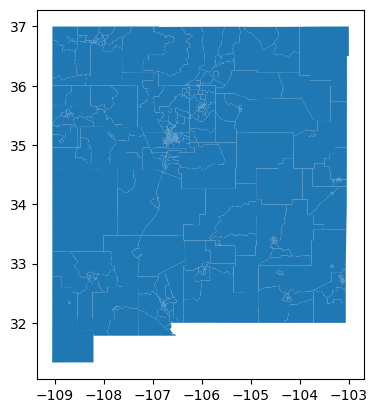

In [91]:
tracts.plot() ;


In [92]:
parties.head()

,attributes,geometry,longitude,latitude,type,address,datetime
90,"{'OBJECTID': 942739, 'BlockAddress': 'BELL AVE...","{'x': -106.56216455956681, 'y': 35.07078156107...",-106.562165,35.070782,39-2 LOUD PARTY,BELL AVE SE / GROVE ST SE,2024-10-14 19:08:22
281,"{'OBJECTID': 942930, 'BlockAddress': '500 BLOC...","{'x': -106.50502833971281, 'y': 35.07822896897...",-106.505028,35.078229,39-2 LOUD PARTY,500 BLOCK GEORGENE DR NE,2024-07-09 00:17:21
302,"{'OBJECTID': 942951, 'BlockAddress': '900 BLOC...","{'x': -106.71498602487151, 'y': 35.09889540831...",-106.714986,35.098895,39-2 LOUD PARTY,900 BLOCK 68TH ST NW,2024-10-18 23:30:48
372,"{'OBJECTID': 943021, 'BlockAddress': '6200 BLO...","{'x': -106.5749128958185, 'y': 35.10198171835737}",-106.574913,35.101982,39-2 LOUD PARTY,6200 BLOCK INDIAN SCHOOL RD NE,2024-07-28 04:03:05
484,"{'OBJECTID': 943133, 'BlockAddress': '12700 BL...","{'x': -106.50235129279248, 'y': 35.09726920480...",-106.502351,35.097269,39-2 LOUD PARTY,12700 BLOCK INDIAN SCHOOL RD NE,2024-06-22 00:23:50


In [93]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 90 to 29871
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   attributes  131 non-null    object        
 1   geometry    131 non-null    object        
 2   longitude   131 non-null    float64       
 3   latitude    131 non-null    float64       
 4   type        131 non-null    object        
 5   address     131 non-null    object        
 6   datetime    131 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 8.2+ KB


In [94]:
# Create geometry for parties data
parties_geo = gpd.GeoDataFrame(
    parties,
    geometry=gpd.points_from_xy(
        parties.longitude,
        parties.latitude
    )
)
parties_geo.head()


,attributes,geometry,longitude,latitude,type,address,datetime
90,"{'OBJECTID': 942739, 'BlockAddress': 'BELL AVE...",POINT (-106.56216 35.07078),-106.562165,35.070782,39-2 LOUD PARTY,BELL AVE SE / GROVE ST SE,2024-10-14 19:08:22
281,"{'OBJECTID': 942930, 'BlockAddress': '500 BLOC...",POINT (-106.50503 35.07823),-106.505028,35.078229,39-2 LOUD PARTY,500 BLOCK GEORGENE DR NE,2024-07-09 00:17:21
302,"{'OBJECTID': 942951, 'BlockAddress': '900 BLOC...",POINT (-106.71499 35.0989),-106.714986,35.098895,39-2 LOUD PARTY,900 BLOCK 68TH ST NW,2024-10-18 23:30:48
372,"{'OBJECTID': 943021, 'BlockAddress': '6200 BLO...",POINT (-106.57491 35.10198),-106.574913,35.101982,39-2 LOUD PARTY,6200 BLOCK INDIAN SCHOOL RD NE,2024-07-28 04:03:05
484,"{'OBJECTID': 943133, 'BlockAddress': '12700 BL...",POINT (-106.50235 35.09727),-106.502351,35.097269,39-2 LOUD PARTY,12700 BLOCK INDIAN SCHOOL RD NE,2024-06-22 00:23:50


In [95]:
parties_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 131 entries, 90 to 29871
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   attributes  131 non-null    object        
 1   geometry    131 non-null    geometry      
 2   longitude   131 non-null    float64       
 3   latitude    131 non-null    float64       
 4   type        131 non-null    object        
 5   address     131 non-null    object        
 6   datetime    131 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), geometry(1), object(3)
memory usage: 8.2+ KB


See if a point is inside a tract polygon

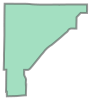

In [96]:
tracts.iloc[0]['geometry']


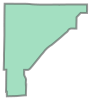

In [97]:
tracts['geometry'].iloc[0]


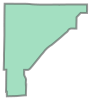

In [98]:
tracts['geometry'][0]


In [99]:
tracts0 = tracts.geometry.iloc[0]
parties0 = parties_geo.geometry.iloc[0]


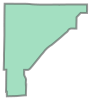

In [100]:
tracts0


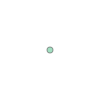

In [101]:
parties0


In [102]:
tracts0.contains(parties0)


False

## Tracts

In [103]:
[ x for x in dir(tracts0) if '_' not in x ]


['area',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'coords',
 'covers',
 'crosses',
 'difference',
 'disjoint',
 'distance',
 'dwithin',
 'envelope',
 'equals',
 'exterior',
 'geometryType',
 'interiors',
 'interpolate',
 'intersection',
 'intersects',
 'length',
 'normalize',
 'overlaps',
 'project',
 'relate',
 'reverse',
 'segmentize',
 'simplify',
 'svg',
 'touches',
 'type',
 'union',
 'within',
 'wkb',
 'wkt',
 'xy']

In [104]:
type(tracts0)

shapely.geometry.polygon.Polygon

In [105]:
type(parties0)

shapely.geometry.point.Point

Find the centroid

In [106]:
print(tracts0.centroid)


POINT (-108.19607648249088 36.741085756281294)


## Parties

Pull out lat or long for a point

In [107]:
[ x for x in dir(parties0) if '_' not in x ]


['area',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'coords',
 'covers',
 'crosses',
 'difference',
 'disjoint',
 'distance',
 'dwithin',
 'envelope',
 'equals',
 'geometryType',
 'interpolate',
 'intersection',
 'intersects',
 'length',
 'm',
 'normalize',
 'overlaps',
 'project',
 'relate',
 'reverse',
 'segmentize',
 'simplify',
 'svg',
 'touches',
 'type',
 'union',
 'within',
 'wkb',
 'wkt',
 'x',
 'xy',
 'y',
 'z']

In [108]:
parties0.x


-106.56216455956681

In [109]:
parties0.y


35.07078156107291

Distance between points

In [110]:
parties1 = parties_geo.geometry.iloc[1]


In [111]:
dist = geopy.distance.geodesic((parties0.y, parties0.x), (parties1.y, parties1.x)) # can calculate distance for EV
dist.miles


3.2784922968333166

Count the number of loud party incidents in each tract

In [112]:
parties_geo.shape

(131, 7)

In [113]:
tracts['incidents'] = 0

for _, incident in parties_geo.iterrows():
  for idx, tract in tracts.iterrows():
    if tract['geometry'].contains(incident['geometry']):
      tracts.loc[idx,'incidents'] += 1
      break


In [114]:
tracts['incidents'].sum()

np.int64(131)

In [115]:
tracts['incidents'].value_counts().sort_index( ascending = False )

,count
incidents,
7,1
6,1
5,3
4,4
3,5
2,18
1,36
0,431


In [116]:
tracts[['GEOID','incidents']].sort_values( by = ['incidents', 'GEOID'], ascending = False )[:15]

,GEOID,incidents
123,35001004737,7
365,35001000300,6
27,35001004750,5
389,35001000901,5
371,35001000704,5
384,35001003714,4
393,35001000713,4
369,35001000603,4
317,35001000401,4
325,35001004741,3


Keep tracks that have had at least one incident

In [117]:
tracts_abq = tracts[tracts['incidents'] >= 1].copy()
tracts_abq.head()


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,incidents
5,35,001,004713,35001004713,47.13,Census Tract 47.13,G5020,S,2825492.0,0.0,+35.0486331,-106.7488369,"POLYGON ((-106.76014 35.0554, -106.75882 35.05...",2
6,35,001,004712,35001004712,47.12,Census Tract 47.12,G5020,S,6931475.0,24374.0,+35.0680642,-106.7583700,"POLYGON ((-106.7918 35.06324, -106.79114 35.06...",2
10,35,001,004729,35001004729,47.29,Census Tract 47.29,G5020,S,4624664.0,435488.0,+35.1320653,-106.6950082,"POLYGON ((-106.70388 35.10791, -106.70367 35.1...",1
13,35,001,004720,35001004720,47.20,Census Tract 47.20,G5020,S,2721480.0,72299.0,+35.1995906,-106.6886481,"POLYGON ((-106.70326 35.19695, -106.70326 35.1...",1
25,35,001,004739,35001004739,47.39,Census Tract 47.39,G5020,S,1996108.0,1508.0,+35.0655742,-106.7356903,"POLYGON ((-106.74271 35.07254, -106.7426 35.07...",1


In [118]:
tracts_abq.set_index('TRACTCE', inplace = True)


In [119]:
tracts_abq


,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,incidents
TRACTCE,,,,,,,,,,,,,
004713,35,001,35001004713,47.13,Census Tract 47.13,G5020,S,2825492.0,0.0,+35.0486331,-106.7488369,"POLYGON ((-106.76014 35.0554, -106.75882 35.05...",2
004712,35,001,35001004712,47.12,Census Tract 47.12,G5020,S,6931475.0,24374.0,+35.0680642,-106.7583700,"POLYGON ((-106.7918 35.06324, -106.79114 35.06...",2
004729,35,001,35001004729,47.29,Census Tract 47.29,G5020,S,4624664.0,435488.0,+35.1320653,-106.6950082,"POLYGON ((-106.70388 35.10791, -106.70367 35.1...",1
004720,35,001,35001004720,47.20,Census Tract 47.20,G5020,S,2721480.0,72299.0,+35.1995906,-106.6886481,"POLYGON ((-106.70326 35.19695, -106.70326 35.1...",1
004739,35,001,35001004739,47.39,Census Tract 47.39,G5020,S,1996108.0,1508.0,+35.0655742,-106.7356903,"POLYGON ((-106.74271 35.07254, -106.7426 35.07...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
002900,35,001,35001002900,29,Census Tract 29,G5020,S,4001788.0,0.0,+35.1125585,-106.6434512,"POLYGON ((-106.65863 35.10862, -106.6585 35.10...",3
003724,35,001,35001003724,37.24,Census Tract 37.24,G5020,S,1771490.0,0.0,+35.1510588,-106.5649171,"POLYGON ((-106.57437 35.14635, -106.57432 35.1...",1
001700,35,001,35001001700,17,Census Tract 17,G5020,S,2048194.0,0.0,+35.0792854,-106.6127406,"POLYGON ((-106.62411 35.07405, -106.62408 35.0...",2


In [120]:
fig = px.choropleth_map(
    tracts_abq,
    geojson = tracts_abq.geometry,
    locations=tracts_abq.index,
    color='incidents',
    color_continuous_scale="Viridis",
    map_style = 'carto-positron',
    zoom = 8,
    center = {"lat": 35.0844, "lon": -106.6504},
    opacity = .7
)
fig.update_geos(fitbounds="locations", visible=False)
fig.show()
